In [1]:
import yfinance as yf
import pandas as pd
import os

In [3]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [4]:
sp500.index = pd.to_datetime(sp500.index)

In [5]:
print(sp500)

                   Open         High          Low        Close      Volume  \
Date                                                                         
1950-01-03    16.660000    16.660000    16.660000    16.660000     1260000   
1950-01-04    16.850000    16.850000    16.850000    16.850000     1890000   
1950-01-05    16.930000    16.930000    16.930000    16.930000     2550000   
1950-01-06    16.980000    16.980000    16.980000    16.980000     2010000   
1950-01-09    17.080000    17.080000    17.080000    17.080000     2520000   
...                 ...          ...          ...          ...         ...   
2022-09-06  3930.889893  3942.550049  3886.750000  3908.189941  2209800080   
2022-09-07  3909.429932  3987.889893  3906.030029  3979.870117           0   
2022-09-08  3959.939941  4010.500000  3944.810059  4006.179932           0   
2022-09-09  4022.939941  4076.810059  4022.939941  4067.360107           0   
2022-09-12  4083.669922  4119.279785  4083.669922  4107.279785  

<Axes: xlabel='Date'>

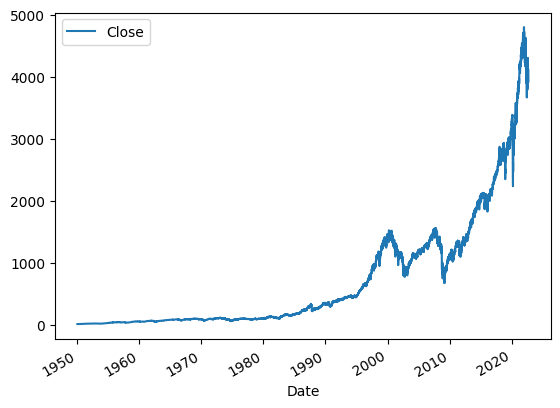

In [6]:
sp500.plot.line(y="Close", use_index=True)

The graph represents the S&P 500 closing prices from around 1950 to 2023, showing a long-term upward trend with periods of volatility. Initially, the index grew slowly, but from the 1980s onward, it experienced exponential growth, reflecting economic expansion and market confidence. Major dips are visible around 2000 (Dot-com bubble), 2008-2009 (Global Financial Crisis), and 2020 (COVID-19 crash), followed by recoveries.  

Overall, despite short-term market downturns, the S&P 500 has, emphasizing the resilience of the stock market. This pattern suggests that while there are fluctuations, the market tends to recover and reach new highs over time.

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

The code trains a **Random Forest Classifier** to predict stock movements using historical **S&P 500** data. It initializes the model with **100 trees** and a **minimum split of 100 samples** to prevent overfitting. The dataset is split into **training (excluding the last 100 rows)** and **testing (last 100 rows)**, using **Close, Volume, Open, High, and Low** prices as predictors. The model is then trained to classify the **Target** variable, likely indicating market direction. This setup helps in trend prediction but requires proper evaluation for real-world accuracy.

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47058823529411764

The **precision score** of **0.47** (or **47.06%**) indicates that when the model predicts a positive class (e.g., market going up), it is correct **47.06% of the time**. This suggests that the model has limited accuracy in predicting stock market movements, which could be due to factors like **feature selection, model parameters, data imbalances, or the unpredictability of financial markets**. Improving feature engineering, trying different models, or fine-tuning hyperparameters may help boost performance.

<Axes: xlabel='Date'>

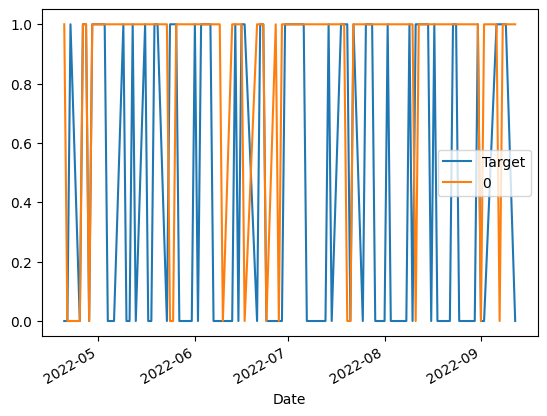

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [15]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3337
1,2401


In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.534777176176593

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.536075
0,0.463925


In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors+= [ratio_column, trend_column]

In [21]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [22]:
print(sp500)

                   Open         High          Low        Close      Volume  \
Date                                                                         
1993-12-14   465.730011   466.119995   462.459991   463.059998   275050000   
1993-12-15   463.059998   463.690002   461.839996   461.839996   331770000   
1993-12-16   461.859985   463.980011   461.859985   463.339996   284620000   
1993-12-17   463.339996   466.380005   463.339996   466.380005   363750000   
1993-12-20   466.380005   466.899994   465.529999   465.850006   255900000   
...                 ...          ...          ...          ...         ...   
2022-09-06  3930.889893  3942.550049  3886.750000  3908.189941  2209800080   
2022-09-07  3909.429932  3987.889893  3906.030029  3979.870117           0   
2022-09-08  3959.939941  4010.500000  3944.810059  4006.179932           0   
2022-09-09  4022.939941  4076.810059  4022.939941  4067.360107           0   
2022-09-12  4083.669922  4119.279785  4083.669922  4107.279785  

In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [25]:
predictions = backtest(sp500, model, new_predictors)

In [26]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,3934
1.0,804


In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5696517412935324

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.546855
0,0.453145


In [30]:
print(predictions)

            Target  Predictions
Date                           
2003-11-14       0          0.0
2003-11-17       0          1.0
2003-11-18       1          1.0
2003-11-19       0          0.0
2003-11-20       1          1.0
...            ...          ...
2022-09-06       1          0.0
2022-09-07       1          0.0
2022-09-08       1          0.0
2022-09-09       1          0.0
2022-09-12       0          0.0

[4738 rows x 2 columns]


The RandomForestClassifier model was trained to predict whether the S&P 500 index would rise the next day based on historical data. Initially, the model achieved a precision score of 47%, indicating poor predictive performance. However, after incorporating rolling averages and trend-based features, the model's precision improved to 57%, suggesting that these additional predictors helped in capturing market trends better. Despite this improvement, the model still struggles with imbalanced predictions, as it predicts downtrends (0) significantly more than uptrends (1). Overall, while the model shows some ability to identify market trends, its accuracy remains moderate, highlighting the challenges of predicting stock movements with machine learning. Further tuning, feature engineering, or alternative models may be required for better performance.